In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA


file_path = 'wine 2.csv'
df = pd.read_csv(file_path)
df.dropna(subset=['varietal', 'category', 'rating'], inplace=True)

df.head()

,wine,winery,category,designation,varietal,appellation,alcohol,price,rating,reviewer,review
0,J. Lohr 2000 Hilltop Vineyard Cabernet Sauvign...,J. Lohr,Red,Hilltop Vineyard,Cabernet Sauvignon,"Paso Robles, Central Coast, California, US",NaN,$32,87,NaN,"Held back nearly five years, this Cab still ha..."
1,Antucura 2010 Pinot Noir (Vista Flores),Antucura,Red,NaN,Pinot Noir,"Vista Flores, Mendoza Province, Argentina",15%,$17,85,Michael Schachner,"Rubbery, bold and earthy on the nose, then ful..."
2,Quinta do Portal 1999 Quinta do Portal Reserva...,Quinta do Portal,Red,Quinta do Portal Reserva,"Red Blends, Red Blends","Douro, Portugal",NaN,NaN,90,Roger Voss,"Smoky, meaty aromas lead into perfumed fruit f..."
3,Tenuta di Ghizzano 2006 Il Ghizzano Red (Toscana),Tenuta di Ghizzano,Red,Il Ghizzano,"Red Blends, Red Blends","Toscana, Tuscany, Italy",13.5%,$18,86,NaN,The nose is rather neutral save for distant ar...
4,Tenuta San Francesco 2007 Tramonti White (Camp...,Tenuta San Francesco,White,Tramonti,White Blend,"Campania, Southern Italy, Italy",13.5%,$21,85,NaN,"This intriguing blend of Falanghina, Biancolel..."


In [8]:
# module 3 expansion starts here (similarity analysis)
app_expanded = feat_df['appellation'].fillna('').str.get_dummies(sep='|')
cat_ohe = pd.get_dummies(feat_df['category'].fillna('Unknown'), prefix='cat')

num_cols = ['rating','alcohol_pct','price_val']
scaled = MinMaxScaler().fit_transform(feat_df[num_cols].fillna(0))
num_df = pd.DataFrame(
    scaled,
    index=feat_df.index,
    columns=[c+'_scaled' for c in num_cols]
)

feature_matrix = pd.concat([cat_ohe, app_expanded, num_df], axis=1).fillna(0)

cos_sim = cosine_similarity(feature_matrix)
cos_df  = pd.DataFrame(cos_sim,
                       index=feature_matrix.index,
                       columns=feature_matrix.index)

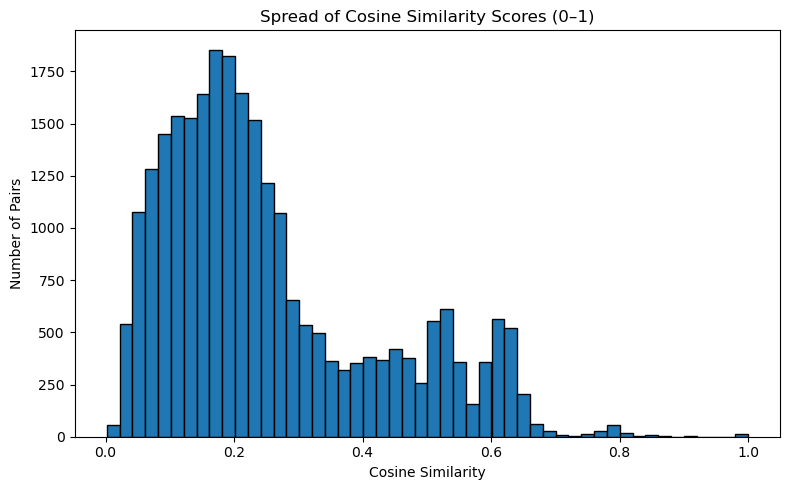

In [9]:
similarity_scores = cos_df.values[np.triu_indices_from(cos_df, k=1)]

fig_width = 8
fig_height = 5
plt.figure(figsize = (fig_width, fig_height))

hist_data = similarity_scores
num_bins = 50
edge_col = 'black'
plt.hist(hist_data, bins=num_bins, edgecolor=edge_col)

plt.title("Spread of Cosine Similarity Scores (0–1)")
plt.xlabel("Cosine Similarity")
plt.ylabel("Number of Pairs")

plt.tight_layout()
plt.show()


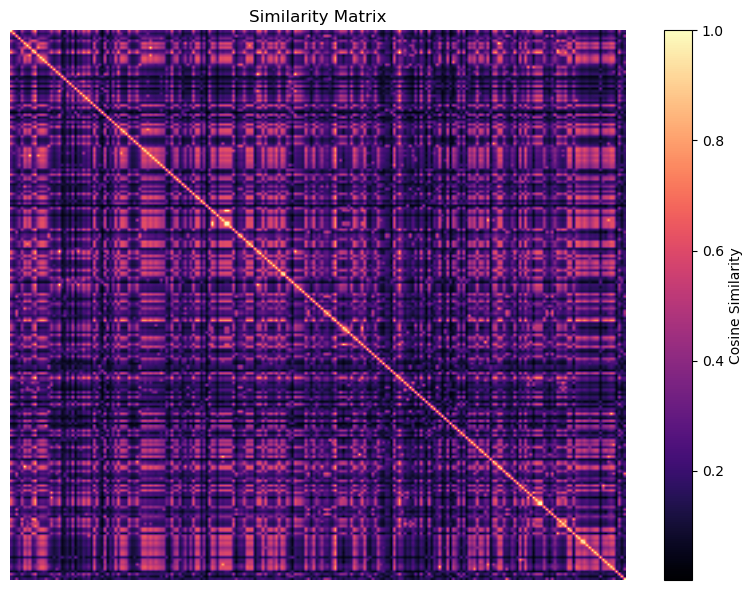

In [10]:
plt.figure(figsize = (8, 6))
similarity_matrix = cos_df.values
plt.imshow(
    similarity_matrix,
    interpolation = 'bilinear',
    cmap = 'magma',
    aspect = 'auto'
    
)
plt.title("Similarity Matrix")
plt.axis('off')
plt.colorbar(label = "Cosine Similarity")
plt.tight_layout()
plt.show()

In [38]:
# build a mapping: varietal → top-rated wine name
wine_map = (
    df
      .sort_values('rating', ascending=False)
      .drop_duplicates('varietal')
      .set_index('varietal')['wine']
)

top3 = [
    'St. Laurent, Other Red',
    'Lambrusco di Sorbara, Italian Red',
    'Morillon, Chardonnay'
]

for q in top3:
    top10 = (
        cos_df.loc[q]
              .drop(q)
              .sort_values(ascending=False)
              .head(10)
    )
    df10 = pd.DataFrame({
        'Wine':       wine_map.reindex(top10.index).values,
        'Varietal':   top10.index,
        'Similarity': top10.values
    }).reset_index(drop=True)

    print(f"\nTop 10 most similar to '{q}':")
    display(df10.style.format({'Similarity': "{:.3f}"}))




Top 10 most similar to 'St. Laurent, Other Red':


,Wine,Varietal,Similarity
0,Zulal 2018 Areni (Vayots Dzor),"Areni, Other Red",0.812
1,Saints Hills 2010 Sv Roko Plavac Mali (Neretvansko Vinogorje),"Plavac Mali, Other Red",0.809
2,Sandlands 2018 Mataro (San Benito County),"Mataro, Mourvèdre",0.700
3,Jeff Cohn 2016 Broken Compass Saitone Vineyard Old Vine Carignane (Russian River Valley),"Carignane, Carignan",0.677
4,Tasca d'Almerita 2017 Guarnaccio Perricone (Sicilia),"Perricone, Italian Red",0.673
5,Concentric Wine Project 2018 Gamay Noir (Columbia Valley (WA)),"Gamay Noir, Gamay",0.670
6,Sevtap 2017 Autumn Claret (Santa Ynez Valley),"Claret, Bordeaux-style Red Blend",0.667
7,Maurodos 2006 San Román (Toro),"Tinta de Toro, Tempranillo",0.666
8,Gill's Pier 2012 Cabernet Franc-Merlot (Leelanau Peninsula),"Cabernet Franc-Merlot, Bordeaux-style Red Blend",0.661
9,Greek Wine Cellars 2018 Flowers Agiorgitiko (Nemea),"Agiorgitiko, Greek Red",0.657



Top 10 most similar to 'Lambrusco di Sorbara, Italian Red':


,Wine,Varietal,Similarity
0,Dal Maso 2016 Pas Dosé Riserva Metodo Classico (Lessini Durello),"Durella, Italian White",0.684
1,Domaine Ansen 2015 Struch Brut Nature Auxerrois (Crémant d'Alsace),"Auxerrois, Other White",0.678
2,Villa di Corlo NV Corleto (Lambrusco Grasparossa di Castelvetro),"Lambrusco Grasparossa, Italian Red",0.648
3,Eugenio Collavini 2005 Brut Ribolla Gialla (Friuli),"Ribolla Gialla, Italian White",0.591
4,Adega Cooperativa do Cartaxo 2018 Plexus Rose Sparkling (Tejo),"Portuguese Sparkling, Sparkling",0.522
5,Apollonis NV Cuvée Authentique Meunier Blanc de Noirs Brut Pinot Meunier (Champagne),"Pinot Meunier, Other Red",0.489
6,BiancaVigna 2017 Rive di Ogliano Brut Nature (Conegliano Valdobbiadene Prosecco Superiore),"Glera, Italian White",0.473
7,Ferrari 2008 Perlé Nero Pinot Nero (Trento),"Pinot Nero, Pinot Noir",0.421
8,Johanneshof Reinisch 2017 Ried Holzspur St. Laurent (Thermenregion),"St. Laurent, Other Red",0.406
9,Zulal 2018 Areni (Vayots Dzor),"Areni, Other Red",0.397



Top 10 most similar to 'Morillon, Chardonnay':


,Wine,Varietal,Similarity
0,Vinkara 2014 Reserve Narince (Ankara),"Narince, Other White",0.787
1,Zeitgeist 2017 Fanucchi Wood Road Vineyard Trousseau Gris (Russian River Valley),"Trousseau Gris, Other White",0.693
2,Rudolf Fürst 2016 Pur Mineral Weisser Burgunder (Franken),"Weisser Burgunder, Pinot Blanc",0.689
3,Domaine Gayrard 2019 Loin de l'Oeil (Gaillac),"Loin de l'Oeil, Other White",0.685
4,Cowhorn 2013 Marsanne-Roussanne (Applegate Valley),"Marsanne-Roussanne, Rhône-style White Blend",0.681
5,Thörle 2013 Saulheimer Probstey Trocken Silvaner (Rheinhessen),"Silvaner, Other White",0.674
6,Vigneti Repetto 2018 Derthona Quadro Timorasso (Colli Tortonesi),"Timorasso, Italian White",0.673
7,Casa da Passarella 2012 O Oenólgo Encruzado (Dão),"Encruzado, Portuguese White",0.671
8,Eder 2018 Smaragd Traminer (Wachau),"Traminer, Other White",0.660
9,Semeli 2015 Feast Moschofilero (Peloponnese),"Moschofilero, Greek White",0.658


In [14]:
# module 4 expansion (clustering)

# calculate alcohol percentage
alcohol_column = df['alcohol']
alcohol_stripped = alcohol_column.str.rstrip('%')
alcohol_pct = alcohol_stripped.astype(float)
df['alcohol_pct'] = alcohol_pct

# cleaning and filtering
price_column = df['price']
price_numbers = price_column.str.replace(r'[^\d.]', '', regex = True)
price_values = pd.to_numeric(price_numbers, errors = 'coerce')
df['price_val'] = price_values

rating_column = df['rating']
rating_values = pd.to_numeric(rating_column, errors = 'coerce')
df['rating'] = rating_values

df.dropna(subset = ['rating', 'alcohol_pct', 'price_val'], inplace = True)

# feature matrix
selected_features = df[['rating', 'alcohol_pct', 'price_val']]
features = selected_features.copy()

# scale
scaler = StandardScaler()
scaler_fit = scaler.fit(features)
x_scaled = scaler_fit.transform(features)

# forcing k = 4
number_of_clusters = 4
random_seed = 42
kmeans_model = KMeans(
    n_clusters = number_of_clusters,
    random_state = random_seed
)

kmeans_model.fit(x_scaled)
cluster_labels = kmeans_model.predict(x_scaled)
df['cluster'] = cluster_labels


C:\Users\casey\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=15.
  warnings.warn(


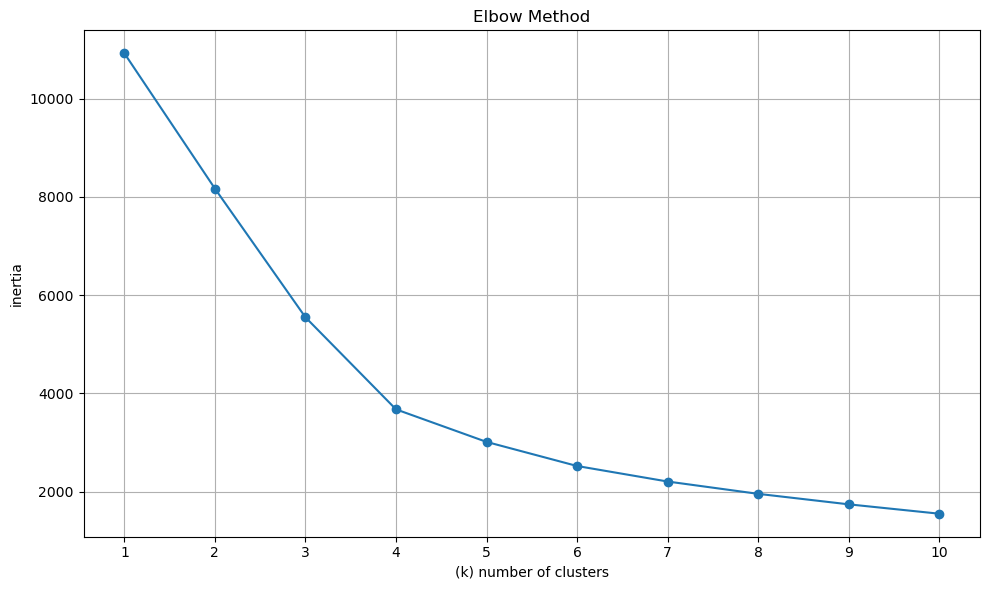

In [15]:
# elbow plot
inertia = []
cluster_range = range(1, 11)
for k in cluster_range:
    n_clusters = k
    model = KMeans(n_clusters = n_clusters, random_state = 42)
    fitted = model.fit(x_scaled)
    inertia_score = fitted.inertia_
    inertia.append(inertia_score)

fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(range(1, 11), inertia, marker = 'o')
ax.set_xticks(range(1, 11))
ax.set_xlabel('(k) number of clusters')
ax.set_ylabel('inertia')
ax.set_title('Elbow Method')
ax.grid(True)
plt.tight_layout()
plt.show()

In [22]:
agg_cos = AgglomerativeClustering(
    n_clusters = 4,
    affinity = 'cosine',    
    linkage = 'average'
)
labels = agg_cos.fit_predict(x_scaled)
df['Cluster'] = labels
print(df['Cluster'].value_counts())

2    1485
1    1477
0     625
3      54
Name: Cluster, dtype: int64


In [40]:
for name, group in df.groupby('Cluster'):
    top10 = group.nlargest(10, 'rating')
    print(f"\nTop 10 wines in '{name}' (n={len(group)}):")
    display(top10[[
        'wine',         
        'category', 
        'appellation',
        'rating',
        'alcohol_pct',
        'price_val'
    ]].rename(columns={'wine':'Wine'}).reset_index(drop=True))



Top 10 wines in '0' (n=625):


,Wine,category,appellation,rating,alcohol_pct,price_val
0,Von Othegraven 2004 Kanzem Altenberg Eiswein F...,Dessert,"Mosel-Saar-Ruwer, Germany",97,8.0,250.0
1,Chateau Ste. Michelle & Dr. Loosen 2014 Eroica...,Dessert,"Horse Heaven Hills, Columbia Valley, Washingto...",94,9.0,60.0
2,Navarro 2011 Cluster Select Late Harvest Musca...,Dessert,"Anderson Valley, Mendocino County, California, US",94,9.9,59.0
3,Nigl 2018 Eiswein Grüner Veltliner (Niederöste...,Dessert,"Niederösterreich, Austria",94,9.5,42.0
4,Schloss Vollrads 2010 Beerenauslese Riesling (...,Dessert,"Rheingau, Germany",94,6.5,200.0
5,Robert Weil 2014 Kiedrick Turmburg Spätlese Ri...,White,"Rheingau, Germany",94,8.0,92.0
6,De Bortoli 2016 Deen Vat Series No 5 Botrytis ...,Dessert,"Riverina, New South Wales, Australia",93,10.5,18.0
7,Seebrich 2006 Niersteiner Oelberg Beerenausles...,White,"Rheinhessen, Germany",93,7.5,48.0
8,Markus Molitor 2012 Ürziger Würzgarten Spätles...,White,"Mosel, Germany",93,7.5,33.0
9,Baron Knyphausen 2011 Hattenheim Ortslage Kabi...,White,"Rheingau, Germany",92,11.0,32.0



Top 10 wines in '1' (n=1477):


,Wine,category,appellation,rating,alcohol_pct,price_val
0,Château Pétrus 2015 Pomerol,Red,"Pomerol, Bordeaux, France",100,15.0,3400.0
1,Sandrone 2016 Le Vigne (Barolo),Red,"Barolo, Piedmont, Italy",98,14.5,155.0
2,Conti Costanti 2015 Riserva (Brunello di Mont...,Red,"Brunello di Montalcino, Tuscany, Italy",98,14.0,224.0
3,Goldschmidt 2006 Plus Game Ranch Single Vineya...,Red,"Oakville, Napa, California, US",98,14.5,150.0
4,Jean-Louis & Fabienne Mann 2011 Resonance Séle...,Dessert,"Alsace, Alsace, France",97,11.0,75.0
5,Brezza 2010 Sarmassa (Barolo),Red,"Barolo, Piedmont, Italy",97,14.5,67.0
6,Royal Tokaji 2016 Betsek Single Vineyard 6 Put...,Dessert,"Tokaji, Hungary",97,10.5,135.0
7,Fattoria Petrolo 2001 San Petrolo White (Tuscany),Dessert,"Tuscany, Tuscany, Italy",97,11.0,60.0
8,Ettore Germano 2015 Vignarionda (Barolo),Red,"Barolo, Piedmont, Italy",97,14.0,154.0
9,Taylor Fladgate NV 325 Anniversary (Port),Port/Sherry,"Port, Portugal",97,20.0,40.0



Top 10 wines in '2' (n=1485):


,Wine,category,appellation,rating,alcohol_pct,price_val
0,José Maria da Fonseca 2017 Periquita Reserva R...,Red,"Península de Setúbal, Portugal",90,90.0,17.0
1,Kopke 2003 Colheita White (Port),Port/Sherry,"Port, Portugal",89,20.0,51.0
2,I Veroni 1999 Vin Santo del Chianti Rufina,White,"Vin Santo del Chianti Rufina, Tuscany, Italy",89,17.0,28.0
3,Ferreira 1994 Traditional LBV (Port),Port/Sherry,"Port, Portugal",89,20.5,20.0
4,Merry Edwards 2011 Sauvignon Blanc (Russian Ri...,White,"Russian River Valley, Sonoma, California, US",88,14.1,32.0
5,Casa da Passarella 2012 Colheita Tinto Red (Dão),Red,"Dão, Portugal",88,13.5,15.0
6,Leone de Castris 2018 Il Medaglione Primitivo ...,Red,"Salento, Southern Italy, Italy",88,13.5,15.0
7,Erste Neue 2017 Puntay Pinot Bianco (Alto Adige),White,"Alto Adige, Northeastern Italy, Italy",88,14.0,30.0
8,Sebastiani 2018 Cabernet Sauvignon (North Coast),Red,"North Coast, North Coast, California, US",88,14.3,18.0
9,Rubinelli Vajol 2014 Valpolicella Classico Su...,Red,"Valpolicella Classico Superiore, Veneto, Italy",88,13.5,25.0



Top 10 wines in '3' (n=54):


,Wine,category,appellation,rating,alcohol_pct,price_val
0,La Fornace 2010 Riserva (Brunello di Montalcino),Red,"Brunello di Montalcino, Tuscany, Italy",89,14.5,130.0
1,Barboursville Vineyards 2013 Octagon Red (Virg...,Red,"Virginia, Virginia, US",88,13.5,55.0
2,Domaine les Goubert 2000 Cuvée Florence (Gigo...,Red,"Gigondas, Rhône Valley, France",88,13.5,50.0
3,Corte Pavone 2015 Campo Marzio (Brunello di M...,Red,"Brunello di Montalcino, Tuscany, Italy",88,15.5,80.0
4,Turnbull 2009 Leopoldina Cabernet Franc (Oakvi...,Red,"Oakville, Napa, California, US",88,14.5,60.0
5,Giacosa Fratelli 2014 Bussia (Barolo),Red,"Barolo, Piedmont, Italy",88,14.5,69.0
6,Mayacamas 2005 Cabernet Sauvignon (Mount Veeder),Red,"Mount Veeder, Napa, California, US",88,13.8,65.0
7,Woodenhead 2011 Wet Kiss Pinot Noir (Russian R...,Red,"Russian River Valley, Sonoma, California, US",88,13.7,52.0
8,Virna Borgogno 2013 Sarmassa (Barolo),Red,"Barolo, Piedmont, Italy",88,14.5,75.0
9,Fattoria La Lecciaia 2012 Vigna Manapetra (Br...,Red,"Brunello di Montalcino, Tuscany, Italy",88,14.0,48.0


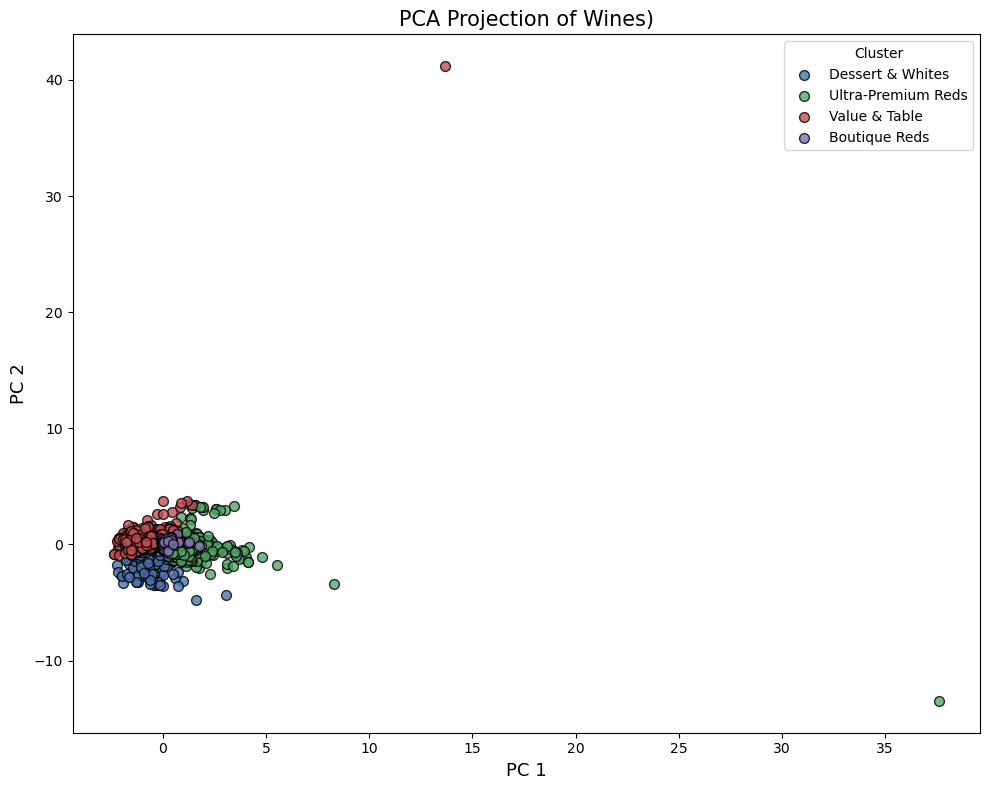

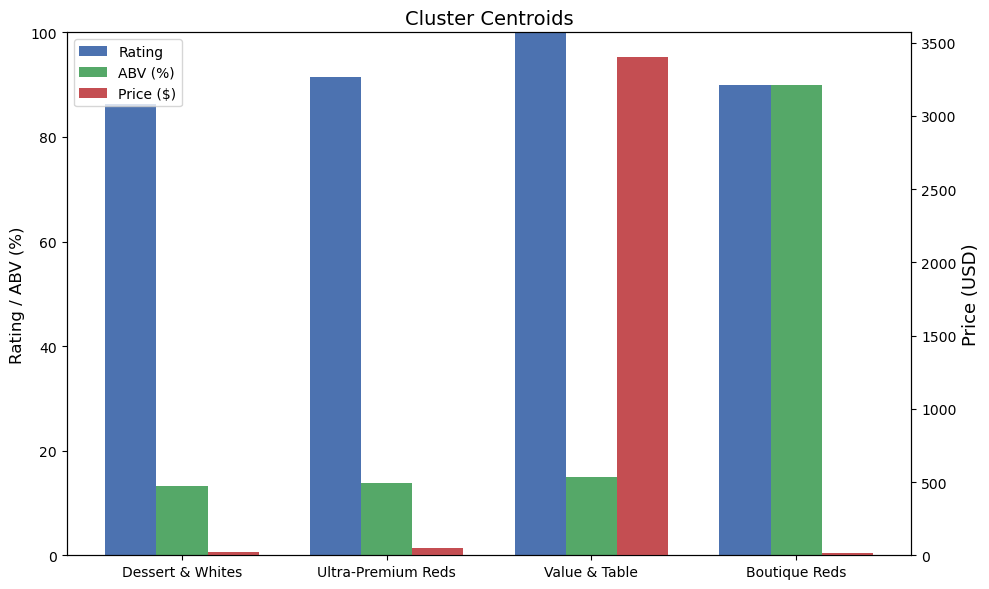

In [20]:
# 2d PCA map

pca = PCA(n_components = 2, random_state = 42)
pcs = pca.fit_transform(x_scaled)

label_map = {
    0: 'Dessert & Whites',
    1: 'Ultra-Premium Reds',
    2: 'Value & Table',
    3: 'Boutique Reds'
}
df['Cluster_name'] = df['Cluster'].map(label_map)

color_map = {
    'Dessert & Whites':   '#4C72B0',
    'Ultra-Premium Reds':  '#55A868',
    'Value & Table':       '#C44E52',
    'Boutique Reds':       '#8172B2'
}

fig, ax = plt.subplots(figsize = (10,8))
for name, color in color_map.items():
    mask = df['Cluster_name'] == name
    ax.scatter(
        pcs[mask,0],
        pcs[mask,1],
        label = name,
        color = color,
        edgecolor = 'k',
        alpha = 0.8,
        s = 50
    )
ax.set_title("PCA Projection of Wines)", fontsize = 15)
ax.set_xlabel("PC 1", fontsize = 13)
ax.set_ylabel("PC 2", fontsize = 13)
ax.legend(title="Cluster", loc = "upper right")
plt.tight_layout()
plt.show()

centroids = scaler.inverse_transform(kmeans_model.cluster_centers_)
centroids_df = pd.DataFrame(
    centroids,
    columns = ['Rating','ABV (%)','Price (USD)'],
    index = [label_map_4[i] for i in range(4)]
)

fig, ax1 = plt.subplots(figsize = (10,6))
x = np.arange(len(centroids_df))
w = 0.25

ax1.bar(x - w, centroids_df['Rating'], w, label = 'Rating', color = '#4C72B0')
ax1.bar(x, centroids_df['ABV (%)'],   w, label = 'ABV (%)', color = '#55A868')
ax1.set_ylabel('Rating / ABV (%)', fontsize = 12)
ax1.set_ylim(0, 100)

ax2 = ax1.twinx()
ax2.bar(x + w, centroids_df['Price (USD)'], w, label = 'Price ($)', color = '#C44E52')
ax2.set_ylabel('Price (USD)', fontsize = 13)

ax1.set_xticks(x)
ax1.set_xticklabels(centroids_df.index, fontsize = 10)
ax1.set_title("Cluster Centroids", fontsize = 14)

h1,l1 = ax1.get_legend_handles_labels()
h2,l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc = 'upper left')
plt.tight_layout()
plt.show()
 